# Lab 7: Optimization and Regularization 

Authored by Nithish Addepalli and Ren Yi, 3-26-2020;
Modified by Runyu Hong, 3-25-2021;

The goal of this lab is to learn how to apply different regularization and optimization strategies in PyTorch using MNIST data.

Here is a list of the techniques we've covered in class
- Optimization
    - SGD
    - SGD (with momentum)
    - Nesterov momentum
    - AdaGrad
    - RMSProp
    - Adam
- Some regularization
    - Dropout
    - Batch normalization


## Problem Setup

In [1]:
import time
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Initialize necessary parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(717)

seed = 345
batch_size = {'train': 64,
              'val': 1000}
input_size = 28 * 28
output_size = 10
n_feature = 3
optim_results = {}

In [8]:
# Data Loader (5-10 mins loading time)
trainset = datasets.MNIST('data', train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))]))
testset = datasets.MNIST('data', train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))]))

mnist_datasets = {'train': trainset, 
            'val': testset}
dataset_sizes = {x: len(mnist_datasets[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(mnist_datasets[x], batch_size=batch_size[x], shuffle=True)
              for x in ['train', 'val']}

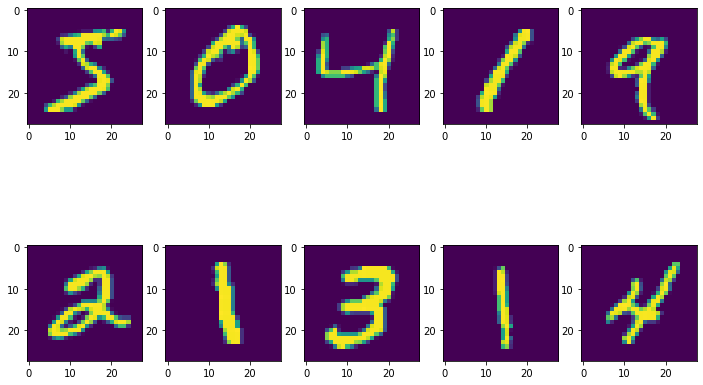

In [9]:
## show some images
plt.figure(figsize = (12, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = dataloaders['train'].dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())

In [12]:
def train_model(model, optimizer, num_epochs=1, verbose = True, print_every = 100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_dict = {'train': [], 'val': []}
    
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, data in enumerate(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size()[0]
                running_corrects += torch.sum(preds == labels).item()
                
                if verbose and batch_idx % print_every == 0:
                    print('Train set | epoch: {:3d} | {:6d}/{:6d} batches | Loss: {:6.4f}'.format(
                        epoch, batch_idx * len(inputs), len(dataloaders[phase].dataset), loss.item()))
                    loss_dict[phase].append(running_loss/((batch_idx + 1) * len(inputs)))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_dict

def populate_result(dictionary, method, train_loss, val_loss):
    dictionary[method] = {}
    dictionary[method]['train_loss'] = np.array(train_loss)
    dictionary[method]['val_loss'] = np.array(val_loss)
    
def plot_loss(result, loss='train_loss', ylim=None):
    plt.plot(result['Baseline'][loss], label='Baseline')
    for k in result.keys():
        if k != 'Baseline':
            plt.plot(result[k][loss], label=k)
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_best_loss(result, loss='val_loss'):
    labels = ['Baseline']
    acc = [np.max(result['Baseline'][loss])]
    for k in result.keys():
        if k != 'Baseline':
            labels.append(k)
            acc.append(np.max(result[k][loss]))

    x = np.arange(len(labels))
    plt.barh(x, acc)
    plt.yticks(x, labels)
    plt.xlabel('Loss')
    plt.show()

### Baseline method

We will later show how different optimization and regularization techniques can improve baseline model performance. But first,
1. What's our baseline model architecture?
2. What's the optimization method used to train the baseline model?
3. How does this optimization method update its parameters.
$$\theta_{t+1} = \theta_{t} - \eta \nabla J(\theta_{t})$$
where $\eta$ denotes the learning rate

In [10]:
class Baseline(nn.Module):
    def __init__(self, n_feature, output_size):
        super(Baseline, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Sequential(nn.Conv2d(1, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.fc = nn.Sequential(nn.Linear(n_feature*4*4, 50),
                                nn.ReLU(),
                                nn.Linear(50, 10))


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc(x)
        return x

In [13]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'Baseline', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3152
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 2.2778
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 2.2295
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 1.2612
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.8846
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.4914
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.4499
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.4444
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.6363
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.4161
train Loss: 1.0644 Acc: 0.6470
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.3766
val Loss: 0.4272 Acc: 0.8657

Training complete in 0m 20s
Best val Acc: 0.865700


## Fancier Optimization

Please complete the following cells and train the "Baseline" model using different optimization methods. Keep the learning rate (initial learning rate) as 0.01. Plot the loss. Which one works the best?

https://pytorch.org/docs/stable/optim.html

### SGD with momentum
1. How does SGD with momentum update its parameters?
$$v_{t+1} = \rho v_{t} + \nabla J(\theta_{t})$$
$$\theta_{t+1} = \theta_{t} - \eta v_{t+1}$$
where $v$ and $\rho$ denote velocity and momentum, respectively.
2. Check out the documentation for SGD in PyTorch and complete the code below (Set momentum=0.5). 

In [ ]:
torch.manual_seed(seed)
model = _ ### Complete the line ###
optimizer = _ ### Complete the line ###
model, loss_dict = _ ### Complete the line ###
populate_result(optim_results, 'SGD_momentum', loss_dict['train'], loss_dict['val'])

### Nesterov momentum

Make a minor change in the above code to apply Nesterov momentum (Set momentum=0.5). 

In [ ]:
torch.manual_seed(seed)
model = _ ### Complete the line ###
optimizer = _ ### Complete the line ###
model, loss_dict = _ ### Complete the line ###
populate_result(optim_results, 'Nesterov_momentum', loss_dict['train'], loss_dict['val'])

### AdaGrad


In [ ]:
torch.manual_seed(seed)
model = _ ### Complete the line ###
optimizer = _ ### Complete the line ###
model, loss_dict = _ ### Complete the line ###
populate_result(optim_results, 'Adagrad', loss_dict['train'], loss_dict['val'])

### RMSprop

In [ ]:
torch.manual_seed(seed)
model = _ ### Complete the line ###
optimizer = _ ### Complete the line ###
model, loss_dict = _ ### Complete the line ###
populate_result(optim_results, 'RMSprop', loss_dict['train'], loss_dict['val'])

### Adam

In [ ]:
torch.manual_seed(seed)
model = _ ### Complete the line ###
optimizer = _ ### Complete the line ###
model, loss_dict = _ ### Complete the line ###
populate_result(optim_results, 'Adam', loss_dict['train'], loss_dict['val'])

In [ ]:
# Plot optimization methods training results
plot_loss(optim_results)

In [ ]:
# Plot optimization methods validation results
plot_best_loss(optim_results)

## Regularization

https://pytorch.org/docs/stable/nn.html

In [14]:
# In order to see effects of regularization on validation set, we need to make some slight modification

## Smaller training set
mnist_datasets['train'].data = mnist_datasets['train'].data[:600]
dataset_sizes = {x: len(mnist_datasets[x]) for x in ['train', 'val']}
dataloaders['train'] = torch.utils.data.DataLoader(mnist_datasets['train'], 
                                                   batch_size=batch_size['train'], shuffle=True)

## Longer training epochs
train_epochs = 25
verbose = False
reg_results = {}

### Baseline model

In [ ]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer, num_epochs=train_epochs, verbose=verbose)
populate_result(reg_results, 'Baseline', loss_dict['train'], loss_dict['val'])

### L1/L2 regularization

L2 regularization is included in most optimizers in PyTorch and can be controlled with the __weight_decay__ parameter.
For L1 regularization, check out this post: https://discuss.pytorch.org/t/simple-l2-regularization/139

### Adding Dropout Layer

1. Check out documentations for __nn.Dropout()__. Modify the Baseline model and add dropout layer to the fully connected layers.
2. Optionally, you may also check out documentations for __nn.Dropout2d()__ to learn how to add Dropout layer to convolution layers.
3. Set the dropout rate to 0.3.

In [ ]:
class DropoutNet(nn.Module):
    def __init__(self, input_size, n_feature, output_size, dropout_rate=0.5):
        super(DropoutNet, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Sequential(nn.Conv2d(1, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.fc = nn.Sequential(nn.Linear(n_feature*4*4, 50),
                                nn.ReLU(),
                                nn.Linear(50, 10))


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc(x)
        return x

In [ ]:
torch.manual_seed(seed)
model = _ ### Complete the line ###
optimizer = optim.Adam(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer, num_epochs=train_epochs, verbose=verbose)
populate_result(reg_results, 'Dropout', loss_dict['train'], loss_dict['val'])

### Adding Batch Normalization
Implement batch normalization in __BatchnormNet__. Think about where you may want to insert the batch normalization layer. (nn.BatchNorm2d)

In [ ]:
class BatchnormNet(nn.Module):
    def __init__(self, n_feature, output_size):
        super(BatchnormNet, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Sequential(nn.Conv2d(1, n_feature, kernel_size=5),
                                   nn.MaxPool2d(2),
                                   nn.ReLU())
        
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature, kernel_size=5),
                                   nn.MaxPool2d(2),
                                   nn.ReLU())
        self.fc = nn.Sequential(nn.Linear(n_feature*4*4, 50),
                                nn.ReLU(),
                                nn.Linear(50, 10))


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc(x)
        return x

In [ ]:
torch.manual_seed(seed)
model = _ ### Complete the line ###
optimizer = optim.Adam(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer, num_epochs=train_epochs, verbose=verbose)
populate_result(reg_results, 'Batchnorm', loss_dict['train'], loss_dict['val'])

In [ ]:
plot_loss(reg_results)

If you define the models correctly, you should see that validation loss using Dropout and Batchnorm start to catch up with the loss of baseline model after baseline model overfits training data.

In [ ]:
plot_loss(reg_results, loss = 'val_loss', ylim=(0.1, 1))

## Exercise: parameter tunning

We've introduced multiple regularization and optimization techniques to improve your model. How can you combine these techniques and perform grid search to find out a set of parameters that maximize your model performance on validation set? Are there other model architectures you'd like to try?

In [ ]:
### If time allowed, build your own model and explore more options/combinations ###